In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmcrameri.cm as cmc
import cartopy.crs as ccrs
import os
from cartopy import geodesic as cgeod
from geopy.distance import geodesic 
from tqdm import tqdm
import warnings
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap, Normalize
from multiprocess import Pool
import cartopy.feature as cfeature
import scipy.stats as stats
from glob import glob
## my own directory
os.chdir("/g/data/k10/dl6968/Semi-variogram_AU/")


In [2]:
from gstools import CovModel
import gstools as gs

class Stab(CovModel):
    def variogram(self, r):
        
        return self.nugget + self.sill * (1 - np.exp(-(3 * r) / self.len_scale))

In [3]:
params={     
    'axes.labelsize'  : '16',   
    'axes.titlesize'  : '16',  
    'xtick.labelsize' :'16',
    'ytick.labelsize' :'16',    
    'lines.linewidth' : '2' ,   
    'legend.fontsize' : '12', 
    'figure.figsize'   : '12, 7'    
}
plt.rcParams.update(params)

In [4]:
# Define seasons based on month
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return "DJF"
    elif month in [3, 4, 5]:
        return "MAM"
    elif month in [6, 7, 8]:
        return "JJA"
    elif month in [9, 10, 11]:
        return "SON"

def get_year(date):
    year = date.year
    return year

In [5]:
def calc_ratio_gamma(N11,N10):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        ratio = np.where(N10 + N11 != 0, 0.5 * (N10 / (N10 + N11)), np.nan)
    return ratio

# Method: weighted bins

begin preprocessing

# Main

In [8]:
df = pd.read_csv("./data/BoM_daily_stations.csv")
exclude_stn = []
for stn_id in df["ID"]:
    bom_id = str(stn_id).zfill(6) 
    if not os.path.exists(f'./data/all_AU_p90_1960_500km/{stn_id}_station_moving_list_all_events.csv'):
        exclude_stn.append(stn_id)
df_1960 = df[~df["ID"].isin(exclude_stn)].reset_index()

In [9]:
df_500km = pd.read_csv("./data/BoM_daily_stations_500km.csv")
df_both = df_1960[df_1960["ID"].isin(df_500km["ID"])].reset_index()
df_both.to_csv("./data/BoM_daily_stations_1960.csv")

In [10]:
bin_files = sorted([f"./data/all_AU_p90_500km/{stn_id}_pair_bins_moving_list_all_events.csv" for stn_id in df_both["ID"]])

In [11]:

fit_model = gs.Spherical(dim=2)  # Choose model type (Exponential, Spherical, Gaussian, etc.)
r_bins = np.arange(1,520,25) #np.arange(1,720,20)#   
rmax = 501
# Function to compute weighted mean of gamma for each bin
def weighted_mean(x,field="gamma"):
    if np.sum(x["Norm_Weight"]) > 0:
        return np.sum(x[field] * x["Norm_Weight"]) / np.sum(x["Norm_Weight"])
    else: 
        return 0

def bins_to_season(file):
    scale_dict = {}
    scale_dict["Season"] = ["DJF", "MAM", "JJA", "SON"]
    year_keys = ["pre1992", "post1992"]
    for keys in year_keys:
        scale_dict[keys] = []
        scale_dict[keys+"_count"] = []
    # df_stn = pd.read_csv(stn_file, index_col=0)
    df_bins = pd.read_csv(file, usecols=lambda col: not col.startswith("Unnamed"))
    df_bins = df_bins[(df_bins["y_fit"]>0) & (df_bins["Bins"]<=rmax)]
    if len(df_bins)==0:
        for years in year_keys:
            scale = np.nan
            scale_dict[years] = scale
    else:
        df_bins["Date"] = pd.to_datetime(df_bins["Date"])
        df_bins["Season"] = df_bins["Date"].apply(get_season)
        df_bins["Year"] = df_bins["Date"].apply(get_year)
        df_pre = df_bins[(df_bins["Year"]<1992) & (df_bins["Year"]>=1960)].reset_index()
        df_post = df_bins[(df_bins["Year"]>=1992) & (df_bins["Year"]<=2023)].reset_index()
        for idf, dfs in enumerate([df_pre, df_post]):
            if len(dfs)==0:
                for seasons in ["DJF", "MAM", "JJA", "SON"]:
                    scale_dict[year_keys[idf]].append(np.nan)
                    scale_dict[year_keys[idf]+"_count"].append(np.nan)
            else:
                dfs["Tot"] = dfs["N11"] + dfs["N10"]
                mean_stations_per_bin = dfs.groupby(["Season", "Bins"])["Tot"].transform("mean")
                dfs["Raw_Weight"] = dfs["Tot"] / mean_stations_per_bin
                ## normalise weight
                dfs["Norm_Weight"] = dfs.groupby(["Season", "Bins"])["Raw_Weight"].transform(lambda x: x / x.sum())
                
                # Apply the weighted mean function per Season & Bin
                ivw_gamma = dfs.groupby(["Season", "Bins"]).apply(lambda x: weighted_mean(x, field="gamma"), include_groups=False
                                                                   ).reset_index(name="IVW_Gamma")
                # bins_yfit_dict = {}
                # bins_scale_dict = {}
                for seasons in ["DJF", "MAM", "JJA", "SON"]:
                    bins = ivw_gamma[ivw_gamma["Season"]==seasons]["Bins"].values
                    gamma = ivw_gamma[ivw_gamma["Season"]==seasons]["IVW_Gamma"].values
                    scale_dict[year_keys[idf]+"_count"].append(len(np.unique(dfs[dfs["Season"]==seasons]["Date"])))
                    if len(gamma)==0:
                        scale = np.nan
                        
                    else:
                        try:
                            gamma_fit = gamma[gamma>0]
                            bins_fit = bins[gamma>0]
                            _ = fit_model.fit_variogram(bins_fit, gamma_fit)#, sill=0.5-0.025, nugget=0.025)
                            y_fit = fit_model.variogram(bins)
                            # if fit_model.sill + fit_model.nugget<=0.5:
                            scale = fit_model.len_scale
                            # else:
                            #     scale = range_from_gamma(fit_model, bins,gamma,0.95)
                        except RuntimeError:
                            # try:
                            #     gamma_fit = gamma[gamma>0]
                            #     bins_fit = bins[gamma>0]
                            #     _ = fit_model.fit_variogram(bins_fit, gamma_fit,init_guess={"nugget":0})#, sill=0.5-0.025, nugget=0.025)
                            #     y_fit = fit_model.variogram(bins)
                            # except RuntimeError:
                                scale = fit_model.len_scale
                                y_fit = np.zeros_like(bins)
                                scale = np.nan
                    scale_dict[year_keys[idf]].append(scale)
        df_year_scale = pd.DataFrame.from_dict(scale_dict)
        df_year_scale.to_csv(file.replace("pair_bins", "trend").replace("all_AU_p90_500km","trend_500km_1960"))


## Main parallel run

In [12]:
max_pool = 28
with Pool(max_pool) as p:
    pool_outputs = list(tqdm(
            p.imap(bins_to_season,
                   bin_files),
        total=len(bin_files),
        position=0, leave=True,  desc="Processing seasonality",
    )
    )
    
p.join()


Processing seasonality: 100%|██████████| 2076/2076 [00:42<00:00, 48.64it/s]


End of preprocessing

In [6]:
df= pd.read_csv("./data/BoM_daily_stations_1960_both.csv")

In [7]:
season_pre_dict = {"DJF":[], "MAM":[], "JJA":[], "SON":[]}
season_post_dict = {"DJF":[], "MAM":[], "JJA":[], "SON":[]}
count_pre_dict = {"DJF":[], "MAM":[], "JJA":[], "SON":[]}
count_post_dict = {"DJF":[], "MAM":[], "JJA":[], "SON":[]}
for spec_id in tqdm(df["ID"],leave=True, position=0):#/scratch/k10/dl6968/all_AU_p90_qc ./data/all_AU_p90_500km/
    df_trend = pd.read_csv(f"./data/trend_500km_1960/{spec_id}_trend_moving_list_all_events.csv",index_col=0)
    for seasons in ["DJF", "MAM", "JJA", "SON"]:
        season_pre_dict[seasons].append( df_trend[df_trend["Season"]==seasons]["pre1992"].values[0])
        season_post_dict[seasons].append( df_trend[df_trend["Season"]==seasons]["post1992"].values[0])
        count_pre_dict[seasons].append( df_trend[df_trend["Season"]==seasons]["pre1992_count"].values[0])
        count_post_dict[seasons].append( df_trend[df_trend["Season"]==seasons]["post1992_count"].values[0])

100%|██████████| 2070/2070 [01:27<00:00, 23.62it/s]


# NRM regions

In [8]:
# Load the shapefile of regions
regions_gdf = gpd.read_file("/g/data/k10/dl6968/Rain_gauge_scale/data/NRM_modified/NRM_modified.shp") 

In [9]:
geometry = [Point(xy) for xy in zip(df["Longitude"], df["Latitude"])]
stations_gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
regions_gdf = regions_gdf.to_crs("EPSG:4326")

# Perform a spatial join
stations_with_regions = gpd.sjoin(stations_gdf, regions_gdf, how="left", predicate="within")

WT_stn = stations_with_regions[stations_with_regions["code"]=="WT"]
SFW_stn = stations_with_regions[stations_with_regions["code"]=="SSWFW"]
SFE_stn = stations_with_regions[stations_with_regions["code"]=="SSWFE"]
VICW_stn = stations_with_regions[stations_with_regions["code"]=="SSVW"]
VICE_stn = stations_with_regions[stations_with_regions["code"]=="SSVE"]
TASW_stn = stations_with_regions[stations_with_regions["code"]=="SSTW"]
TASE_stn = stations_with_regions[stations_with_regions["code"]=="SSTE"]
RW_stn = stations_with_regions[stations_with_regions["code"]=="RW"]
RE_stn = stations_with_regions[stations_with_regions["code"]=="RE"]
MNW_stn = stations_with_regions[stations_with_regions["code"]=="MNW"]
MNE_stn = stations_with_regions[stations_with_regions["code"]=="MNE"]
MB_stn = stations_with_regions[stations_with_regions["code"]=="MB"]
ECS_stn = stations_with_regions[stations_with_regions["code"]=="ECS"]
ECN_stn = stations_with_regions[stations_with_regions["code"]=="ECN"]
CS_stn = stations_with_regions[stations_with_regions["code"]=="CS"]

In [10]:
def nrm_season_weighted(df_in, id_df):
    djf_scale = np.array([df_in[df_in["ID"]==spec_id]["DJF"].values[0] for spec_id in id_df])
    mam_scale = np.array([df_in[df_in["ID"]==spec_id]["MAM"].values[0] for spec_id in id_df])
    jja_scale = np.array([df_in[df_in["ID"]==spec_id]["JJA"].values[0] for spec_id in id_df])
    son_scale = np.array([df_in[df_in["ID"]==spec_id]["SON"].values[0] for spec_id in id_df])
    
    djf_valid = djf_scale[~np.isnan(djf_scale)]
    mam_valid = mam_scale[~np.isnan(mam_scale)]
    jja_valid = jja_scale[~np.isnan(jja_scale)]
    son_valid = son_scale[~np.isnan(son_scale)]
    
    # djf_valid[djf_valid>1500] = 1500
    # mam_valid[mam_valid>1500] = 1500
    # jja_valid[jja_valid>1500] = 1500
    # son_valid[son_valid>1500] = 1500
    return [djf_valid, mam_valid, jja_valid, son_valid]

In [11]:
season_pre_dict["ID"] = df["ID"].values
season_post_dict["ID"] = df["ID"].values
count_pre_dict["ID"] = df["ID"].values
count_post_dict["ID"] = df["ID"].values

df_season_pre = pd.DataFrame.from_dict(season_pre_dict)
df_season_post = pd.DataFrame.from_dict(season_post_dict)

df_count_pre = pd.DataFrame.from_dict(count_pre_dict)
df_count_post = pd.DataFrame.from_dict(count_post_dict)

nrm_sub_pre_dict = {}
nrm_sub_post_dict = {}
nrm_sub_pre_count = {}
nrm_sub_post_count = {}
for regions in stations_with_regions["code"].unique()[:-1]:
    nrm_sub_pre_dict[regions] = nrm_season_weighted(df_season_pre,stations_with_regions[stations_with_regions["code"]==regions]["ID"])
    nrm_sub_post_dict[regions] = nrm_season_weighted(df_season_post,stations_with_regions[stations_with_regions["code"]==regions]["ID"])
    nrm_sub_pre_count[regions] = nrm_season_weighted(df_count_pre,stations_with_regions[stations_with_regions["code"]==regions]["ID"])
    nrm_sub_post_count[regions] = nrm_season_weighted(df_count_post,stations_with_regions[stations_with_regions["code"]==regions]["ID"])

In [12]:
## change the keys so I can remember them easily
for nrm_dicts in [nrm_sub_pre_dict, nrm_sub_post_dict, nrm_sub_pre_count, nrm_sub_post_count]:
    nrm_dicts["SFW"] = nrm_dicts.pop("SSWFW")
    nrm_dicts["SFE"] = nrm_dicts.pop("SSWFE")
    nrm_dicts["VICW"] = nrm_dicts.pop("SSVW")
    nrm_dicts["VICE"] = nrm_dicts.pop("SSVE")
    nrm_dicts["TASW"] = nrm_dicts.pop("SSTW")
    nrm_dicts["TASE"] = nrm_dicts.pop("SSTE")

In [13]:
rcolors = [
     "blue",  "lightgray",  "salmon",
     "orange",  "black",  "fuchsia",
     "navy",  "lightgreen", "maroon",
     "red",  "cyan",  "dodgerblue",
     "tan", "darkgreen",  "darkcyan"
]
def index_to_letter_lower(index):
    return chr(96 + index)

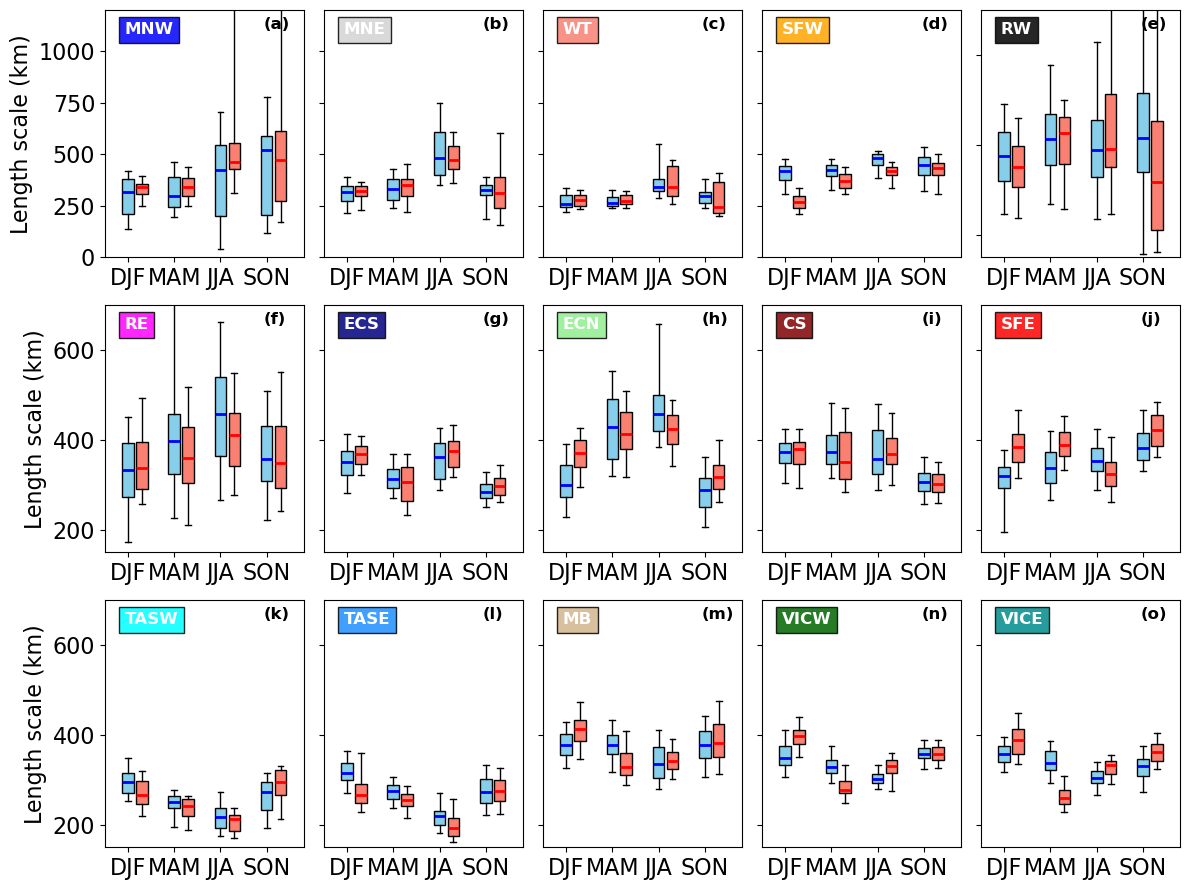

In [14]:
plt.figure(figsize=(12,9))
# Define positions for each group
positions_pre = [1, 2, 3, 4]
# Shift the positions slightly for the second set
shift = 0.3
positions_post = [x + shift for x in positions_pre]
for i, region in enumerate(["MNW", "MNE", "WT", "SFW", "RW", "RE", "ECS", "ECN", "CS", 
    "SFE", "TASW", "TASE", "MB", "VICW", "VICE"]):
    ax = plt.subplot(3,5,i+1)
    pre_data = [data[~np.isnan(data)] for data in nrm_sub_pre_dict[region]]
    bp_pre = plt.boxplot(pre_data, widths=0.25,whis=(5,95),
                         positions=positions_pre, showfliers=False,patch_artist=True)
    for box in bp_pre['boxes']:
        box.set_facecolor("skyblue")
    for median in bp_pre['medians']:
        median.set_color("blue")  # Set color for pre medians
        median.set_linewidth(2)     # Optional: change line width 
    
    post_data = [data[~np.isnan(data)] for data in nrm_sub_post_dict[region]]
    bp_post = plt.boxplot(post_data, widths=0.25,whis=(5,95),
                          positions=positions_post,showfliers=False,patch_artist=True)
    # Change the box color for post data
    for box in bp_post['boxes']:
        box.set_facecolor("salmon")
    for median in bp_post['medians']:
        median.set_color("red")  # Set color for pre medians
        median.set_linewidth(2)     # Optional: change line width 
    plt.xticks([1,2,3,4], ["DJF", "MAM", "JJA", "SON"])
    if i % 5 == 0:
            plt.ylabel("Length scale (km)")
    else:
        ax.set_yticklabels([])
    # plt.ylabel("Length scale (km)")
    ax.text(0.1, 0.95, region, transform=ax.transAxes, fontsize=12, color="w", fontweight="bold",
                 verticalalignment='top', bbox=dict(facecolor=rcolors[i], alpha=0.85))
    ax.text(0.8, 0.97, f"({index_to_letter_lower(i+1)})", transform=ax.transAxes, fontsize=12, color="k", fontweight="bold",
                 verticalalignment='top' )
    # plt.title(region)
    if i +1<5:
         plt.ylim([-1,1200])
    else:
        plt.ylim([150,700])
plt.tight_layout()
plt.savefig("/g/data/k10/dl6968/Semi-variogram_AU/figures/Figure_trend_box_plot_scale.png", dpi=200, bbox_inches="tight")

In [15]:
import scipy.stats as stats
from matplotlib.lines import Line2D
import seaborn as sns

In [16]:
stats_dict = {}
diff_dict = {}
region_list = ["MNW", "MNE", "WT", "SFW", "RW", "RE", "ECS", "ECN", "CS", 
    "SFE", "TASW", "TASE", "MB", "VICW", "VICE"]
for region in region_list:
    stats_dict[region] = np.zeros(4).astype(float)
    diff_dict[region] = np.zeros(4).astype(float)
    for i in range(0,4):
        
        stats_dict[region][i] = stats.median_test(nrm_sub_pre_dict[region][i], nrm_sub_post_dict[region][i])[1]
        diff_dict[region][i] = np.nanmedian(nrm_sub_post_dict[region][i]) - np.nanmedian(nrm_sub_pre_dict[region][i]) 
        
pvalue_diff = np.array([np.array(stats_dict[region]) for region in region_list])
diff_val = np.array([np.array(diff_dict[region]) for region in region_list])


In [17]:
np.save('./data/trend_pval_1960_all.npy', pvalue_diff)

In [18]:
np.save('./data/trend_diff_1960_all.npy', diff_val)

In [38]:
from matplotlib.colors import LinearSegmentedColormap

# colors = [
#     (0.0, "navy"),    # Min value
#     (0.35, "cornflowerblue"),
#     (0.49, "lightblue"),  # Near-zero negative
#     (0.5, "white"),  # Near-zero positive
#     (0.51, "mistyrose"),  # Near-zero negative
#     (0.65, "saddlebrown"),
#     (1.0, "maroon")      # Max value
# ]

# custom_cmap = LinearSegmentedColormap.from_list("custom_bwr", colors)
def make_center_white(cmap_name='bwr', ncolors=256, white_at=0.5):
    """Modify an existing diverging colormap so the center color is white."""
    base = plt.get_cmap(cmap_name, ncolors)
    colors = base(np.linspace(0, 1, ncolors))
    
    # Set the center color to white
    center_index = int(ncolors * white_at)
    colors[center_index] = [1, 1, 1, 1]  # RGBA for white
    
    # Optional: Smooth transition near white
    # You can adjust colors[center_index ± 1 or 2] to also fade into white
    
    new_cmap = LinearSegmentedColormap.from_list(f"{cmap_name}_white", colors)
    return new_cmap

# Create the modified colormap
custom_cmap = make_center_white('cmc.vik_r')

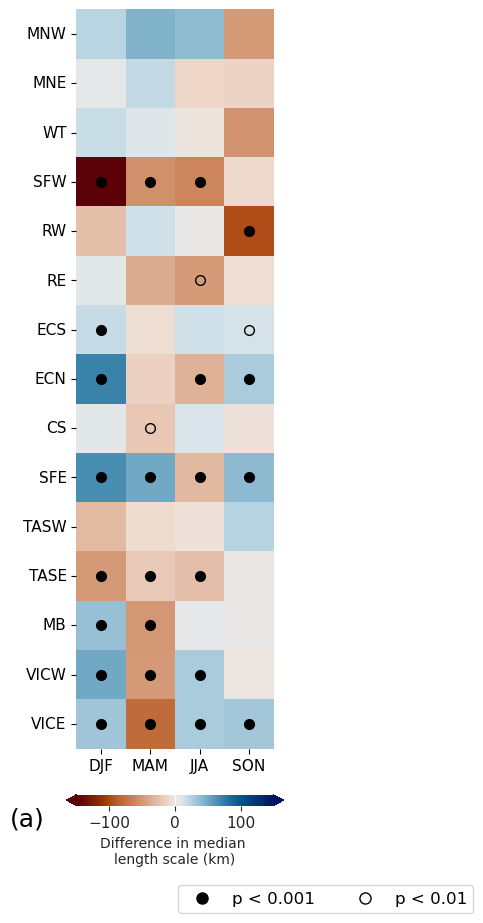

In [39]:
fig = plt.figure(figsize=(4,12))
ax = fig.add_subplot(111)
with sns.axes_style("white"):
   # Disable the colorbar for each heatmap (cbar=False)
   g1 = sns.heatmap(diff_val,  square=True,
                        vmin=-150, vmax=150, cmap=custom_cmap, cbar=True,
                    cbar_kws={'extend': 'both','shrink': 0.7,"pad":0.05,"orientation":"horizontal"})
   
cbar = g1.collections[0].colorbar
cbar.set_label('Difference in median \nlength scale (km)',fontsize=10)
cbar.ax.tick_params(labelsize=11)
ax.set_xticks(np.arange(4) + 0.5)
_ = ax.set_xticklabels(["DJF","MAM","JJA", "SON"], rotation=0,fontsize=11)
_ = ax.set_yticklabels(region_list, rotation=0,fontsize=11)
for i in range(pvalue_diff.shape[0]):
      for j in range(pvalue_diff.shape[1]):
         p = pvalue_diff[i, j]
         if p < 0.001:
               # Solid black dot
               markerfacecolor = "black"
               markeredgecolor = "black"
         elif p < 0.01:
               # Hollow dot (no face color, just edge)
               markerfacecolor = "none"
               markeredgecolor = "black"
         else:
               continue  # Do nothing if p-value doesn't meet criteria.
         # Plot the marker at the center of cell (i, j)
         ax.plot(j + 0.5, i + 0.5, marker='o', markersize=7,
                  markerfacecolor=markerfacecolor, markeredgecolor=markeredgecolor)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black',
           markeredgecolor='black', markersize=8, label='p < 0.001'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='none',
           markeredgecolor='black', markersize=8, label='p < 0.01')
]

# Add a common legend to the figure.
# Adjust bbox_to_anchor and loc as needed.
fig.legend(handles=legend_elements, loc='lower left', ncol=2, bbox_to_anchor=(0.5, 0.12))
plt.gcf().text(0.1, 0.2,"(a)", fontsize=18)
plt.savefig("/g/data/k10/dl6968/Semi-variogram_AU/figures/Figure_trend_heatmap.png", dpi=200, bbox_inches="tight")

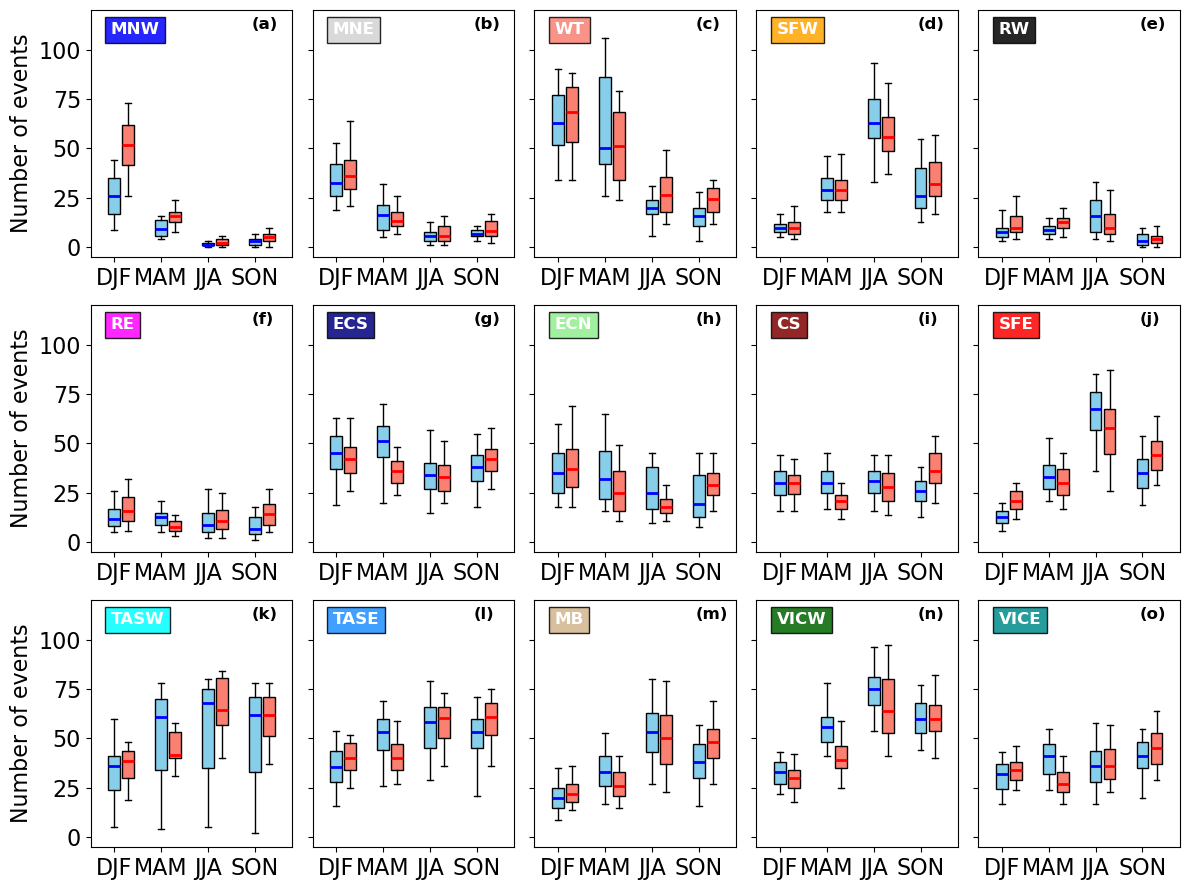

In [20]:
plt.figure(figsize=(12,9))
# Define positions for each group
positions_pre = [1, 2, 3, 4]
# Shift the positions slightly for the second set
shift = 0.3
positions_post = [x + shift for x in positions_pre]
for i, region in enumerate(["MNW", "MNE", "WT", "SFW", "RW", "RE", "ECS", "ECN", "CS", 
    "SFE", "TASW", "TASE", "MB", "VICW", "VICE"]):
    ax = plt.subplot(3,5,i+1)
    
    bp_pre = plt.boxplot(nrm_sub_pre_count[region], widths=0.25,whis=(5,95),
                         positions=positions_pre, showfliers=False,patch_artist=True)
    for box in bp_pre['boxes']:
        box.set_facecolor("skyblue")
    for median in bp_pre['medians']:
        median.set_color("blue")  # Set color for pre medians
        median.set_linewidth(2)     # Optional: change line width 
        
    bp_post = plt.boxplot(nrm_sub_post_count[region], widths=0.25,whis=(5,95),
                          positions=positions_post,showfliers=False,patch_artist=True)
    # Change the box color for post data
    for box in bp_post['boxes']:
        box.set_facecolor("salmon")
    for median in bp_post['medians']:
        median.set_color("red")  # Set color for pre medians
        median.set_linewidth(2)     # Optional: change line width 
    plt.xticks([1,2,3,4], ["DJF", "MAM", "JJA", "SON"])

    if i % 5 == 0:
        plt.ylabel("Number of events")
    else:
        ax.set_yticklabels([])
    # plt.title(region)
    ax.text(0.1, 0.95, region, transform=ax.transAxes, fontsize=12, color="w", fontweight="bold",
                 verticalalignment='top', bbox=dict(facecolor=rcolors[i], alpha=0.85))
    ax.text(0.8, 0.97, f"({index_to_letter_lower(i+1)})", transform=ax.transAxes, fontsize=12, color="k", fontweight="bold",
                 verticalalignment='top' )
    plt.ylim([-5,120])
plt.tight_layout()
plt.savefig("/g/data/k10/dl6968/Semi-variogram_AU/figures/Figure_trend_box_plot_count.png", dpi=200, bbox_inches="tight")

In [21]:
import matplotlib.ticker as mticker


In [22]:
num_stats_dict = {}
num_diff_dict = {}
region_list = ["MNW", "MNE", "WT", "SFW", "RW", "RE", "ECS", "ECN", "CS", 
    "SFE", "TASW", "TASE", "MB", "VICW", "VICE"]
for region in region_list:
    num_stats_dict[region] = np.zeros(4).astype(float)
    num_diff_dict[region] = np.zeros(4).astype(float)
    for i in range(0,4):
        
        num_stats_dict[region][i] = stats.median_test(nrm_sub_pre_count[region][i], nrm_sub_post_count[region][i])[1]
        num_diff_dict[region][i] = np.nanmedian(nrm_sub_post_count[region][i]) - np.nanmedian(nrm_sub_pre_count[region][i]) 
        
pvalue_diff_num = np.array([np.array(num_stats_dict[region]) for region in region_list])
diff_val_num = np.array([np.array(num_diff_dict[region]) for region in region_list])

In [23]:
np.save('./data/trend_diff_num_1960_all.npy', diff_val_num)

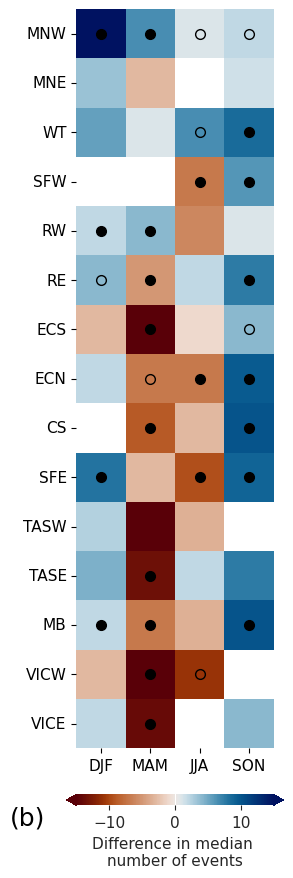

In [41]:
fig = plt.figure(figsize=(4,12))
ax = fig.add_subplot(111)
with sns.axes_style("white"):
   # Disable the colorbar for each heatmap (cbar=False)
   g1 = sns.heatmap(diff_val_num,  square=True,
                        vmin=-15, vmax=15, cmap=custom_cmap, cbar=True,
                    cbar_kws={'extend': 'both','shrink': 0.7,"pad":0.05,"orientation":"horizontal"})
   
cbar = g1.collections[0].colorbar
cbar.set_label('Difference in median \nnumber of events',fontsize=11)
cbar.ax.tick_params(labelsize=11)
# cbar.ax.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))

ax.set_xticks(np.arange(4) + 0.5)
_ = ax.set_xticklabels(["DJF","MAM","JJA", "SON"], rotation=0,fontsize=11)
_ = ax.set_yticklabels(region_list, rotation=0,fontsize=11)
for i in range(pvalue_diff_num.shape[0]):
      for j in range(pvalue_diff_num.shape[1]):
         p = pvalue_diff_num[i, j]
         if p < 0.001:
               # Solid black dot
               markerfacecolor = "black"
               markeredgecolor = "black"
         elif p < 0.01:
               # Hollow dot (no face color, just edge)
               markerfacecolor = "none"
               markeredgecolor = "black"
         else:
               continue  # Do nothing if p-value doesn't meet criteria.
         # Plot the marker at the center of cell (i, j)
         ax.plot(j + 0.5, i + 0.5, marker='o', markersize=7,
                  markerfacecolor=markerfacecolor, markeredgecolor=markeredgecolor)
plt.gcf().text(0.1, 0.2,"(b)", fontsize=18)        
plt.savefig("/g/data/k10/dl6968/Semi-variogram_AU/figures/Figure_count_heatmap.png", dpi=200, bbox_inches="tight")